In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl fsspec -U  -qq ## NEW LINES ##
  !pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes -qq

  basepath = '/content/drive/MyDrive/NLP UTD/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 99.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.12.2 requires transformers<4.47.0, but you have transformers 4.47.0 which is incompatible.


In [ ]:
# standard pythgion libraries
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional
from tqdm import tqdm
import itertools
import json
import joblib
import ast
from datetime import datetime
from difflib import get_close_matches

# Data Science librraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Pytorch
import torch
import torch.nn as nn

# Huggingface Librraies
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftConfig
)

from huggingface_hub import login

# Logging and secrets
import wandb
from google.colab import userdata

In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / 'datasets'

# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = base_folder / 'models'

custom_functions = base_folder/'custom-functions'


In [ ]:
train_data=pd.read_csv(data_folder/'train.csv')


In [ ]:
train_data.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
# List of emotion columns
emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love",
                   "optimism", "pessimism", "sadness", "surprise", "trust"]

# Create a new column with the names of emotions where the value is 1
train_data["emotions"] = train_data[emotions].apply(
    lambda row: " ".join([emotion for emotion in emotions if row[emotion] == 1]), axis=1
)

# Display the DataFrame
print(train_data)

              ID                                              Tweet  anger  \
0     2017-21441  “Worry is a down payment on a problem you may ...      0   
1     2017-31535  Whatever you decide to do make sure it makes y...      0   
2     2017-21068  @Max_Kellerman  it also helps that the majorit...      1   
3     2017-31436  Accept the challenges so that you can literall...      0   
4     2017-22195  My roommate: it's okay that we can't spell bec...      1   
...          ...                                                ...    ...   
7719  2018-01993  @BadHombreNPS @SecretaryPerry If this didn't m...      1   
7720  2018-01784  Excited to watch #stateoforigin tonight! Come ...      0   
7721  2018-04047  Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...      1   
7722  2018-03041  #ThingsIveLearned The wise #shepherd never tru...      0   
7723  2018-03386  I am really flattered and happy to hear those ...      0   

      anticipation  disgust  fear  joy  love  optimism  pessimi

In [ ]:
stack= Dataset.from_pandas(train_data)

In [ ]:
selected_columns = {
    'text': stack['Tweet'],
    'tag': stack['emotions']
}

# Create a new dataset with the selected columns
stack_columns = Dataset.from_dict(selected_columns)

In [ ]:
stack_columns

Dataset({
    features: ['text', 'tag'],
    num_rows: 7724
})

In [ ]:
stack_columns['tag'][0]

'anticipation optimism trust'

In [ ]:
# Set the format to Pandas
stack_columns.set_format(type='pandas')

In [ ]:
df = stack_columns[:]

In [ ]:
# Remove existing quotes first (if any) and then add just one set
import json
df['label'] = df['tag'].str.split().apply(lambda x: json.dumps([tag.strip() for tag in x]))


In [ ]:
df_final = df[['text', 'label']]

In [ ]:
df_final

,text,label
0,“Worry is a down payment on a problem you may ...,"[""anticipation"", ""optimism"", ""trust""]"
1,Whatever you decide to do make sure it makes y...,"[""joy"", ""love"", ""optimism""]"
2,@Max_Kellerman it also helps that the majorit...,"[""anger"", ""disgust"", ""joy"", ""optimism""]"
3,Accept the challenges so that you can literall...,"[""joy"", ""optimism""]"
4,My roommate: it's okay that we can't spell bec...,"[""anger"", ""disgust""]"
...,...,...
7719,@BadHombreNPS @SecretaryPerry If this didn't m...,"[""anger"", ""disgust""]"
7720,Excited to watch #stateoforigin tonight! Come ...,"[""joy"", ""optimism""]"
7721,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...","[""anger"", ""disgust"", ""sadness""]"
7722,#ThingsIveLearned The wise #shepherd never tru...,[]


In [ ]:
class_names = ["anger", "anticipation", "disgust", "fear", "joy", "love",
                   "optimism", "pessimism", "sadness", "surprise", "trust"]

In [ ]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

In [ ]:
stack_selected_columns_final[0]['label']

'["anticipation", "optimism", "trust"]'

In [ ]:
# Split the test set into test and validation sets
train_valid_splits_data = stack_selected_columns_final.train_test_split(test_size=0.2, seed=42)
train_data= train_valid_splits_data['train']
val_data = train_valid_splits_data['test']

In [ ]:
train_val_subset= DatasetDict(
    {"train": train_data, "valid": val_data})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [ ]:
train_val_subset['train']['label'][0]

'["fear", "pessimism", "sadness"]'

In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
tokenizer.eos_token


'<|endoftext|>'

In [ ]:
tokenizer.pad_token

'<|endoftext|>'

In [ ]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [ ]:
tokenizer.additional_special_tokens[1]

'<|im_end|>'

In [ ]:
tokenizer.padding_side

'right'

In [ ]:
tokenizer.chat_template

'{%- if tools %}\n    {{- \'<|im_start|>system\\n\' }}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- messages[0][\'content\'] }}\n    {%- else %}\n        {{- \'You are a helpful assistant.\' }}\n    {%- endif %}\n    {{- "\\n\\n# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>" }}\n    {%- for tool in tools %}\n        {{- "\\n" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- "\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\"name\\": <function-name>, \\"arguments\\": <args-json-object>}\\n</tool_call><|im_end|>\\n" }}\n{%- else %}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- \'<|im_start|>system\\n\' + messages[0][\'content\'] + \'<|im_end|>\\n\' }}\n    {%- else %}\n        {{- \'<|im_start|>system\\nYou are a he

In [ ]:
def formatting_prompts_func(examples, input_field, output_field, prompt_template, output_delimiter, tokenizer, include_eos_token=True):
    """Format a single example or batch of examples"""
    # Debug the input type
    # print("Input type:", type(examples))
    # print("Input content:", examples)

    # Convert to dict if it's a LazyRow
    if hasattr(examples, 'keys'):
        examples = dict(examples)

    # Handle single example case (for dataset.map)
    if isinstance(examples, dict):
        if not isinstance(examples[input_field], (list, tuple)):
            input_text = examples[input_field].strip()
            output_text = examples[output_field]
            output_delimiter = output_delimiter.strip()

            prompt = prompt_template.format(input_text, output_delimiter, output_text)

            if include_eos_token:
                prompt = prompt + tokenizer.eos_token

            return prompt.strip()
        else:
            # Handle batch case
            output_prompts = []
            for i in range(len(examples[input_field])):
                input_text = examples[input_field][i].strip()
                output_text = examples[output_field][i]
                output_delimiter = output_delimiter.strip()

                prompt = prompt_template.format(input_text, output_delimiter, output_text)

                if include_eos_token:
                    prompt = prompt + tokenizer.eos_token
                prompt = prompt.strip()
                output_prompts.append(prompt)

            return output_prompts

    print("Unexpected input format!")
    print("Type:", type(examples))
    print("Content:", examples)
    raise ValueError(f"Expected a dictionary with examples, got {type(examples)}")


In [ ]:
prompt_template = 'Classify the TEXT by selecting all applicable labels from the following list: \
["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"].\
 ### TEXT: {} {} {}'

In [ ]:
output_delimiter = "### LABEL:"
input_field = 'text'
output_field = 'label'

In [ ]:
output_delimiter

'### LABEL:'

In [ ]:
from functools import partial

In [ ]:
formatting_prompts_func_final = partial(formatting_prompts_func,
                                        input_field =input_field,
                                        output_field = output_field,
                                        prompt_template=prompt_template,
                                        output_delimiter=output_delimiter,
                                        tokenizer=tokenizer
)

In [ ]:
samples = formatting_prompts_func_final(train_val_subset['train'][0:3])

In [ ]:
from pprint import pprint
pprint(samples[2], width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", '
 '"fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: @TheSGJournal Step 1: Get '
 'rid of @LittleStokePark Step 2: Prioritise football Step 3: profit? #depressing ### LABEL: ["sadness"]<|endoftext|>')


In [ ]:
single_sample = formatting_prompts_func_final(train_val_subset['train'][1])
pprint(single_sample, width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", '
 '"fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: A not very young man '
 'compiled info on a smiling baby then a mattress created new evil. ### LABEL: ["anger", "anticipation", '
 '"joy"]<|endoftext|>')


In [ ]:
def filter_by_length(example, max_length, tokenizer, prompt_function):
    """Filter a single example based on length"""
    # Convert LazyRow to dict if needed
    example_dict = dict(example) if hasattr(example, 'keys') else example

    prompt = prompt_function(example_dict)  # handles single example
    tokenized_prompt = tokenizer(prompt, add_special_tokens=False, truncation=False, padding=False)
    total_length = len(tokenized_prompt['input_ids'])
    example['keep'] = total_length <= max_length
    return example

# Create partial function
filter_fn = partial(filter_by_length,
                   max_length=1000,
                   tokenizer=tokenizer,
                   prompt_function=formatting_prompts_func_final)

# Now try processing the dataset
train_val_subset = train_val_subset.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/6179 [00:00<?, ? examples/s]

Processing dataset:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 1545
    })
})

In [ ]:
train_val_subset_filtered = train_val_subset.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/6179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
train_val_subset_filtered

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [ ]:
def get_token_ids_in_context(tokenizer, full_string, substring):
    # Tokenize the full string
    full_tokens = tokenizer.encode(full_string, add_special_tokens=False)

    # Find the start and end indices of the substring in the full string
    start_index = full_string.index(substring)
    end_index = start_index + len(substring)

    # Find the corresponding tokens, starting one token earlier
    start_token_index = max(0, len(tokenizer.encode(full_string[:start_index], add_special_tokens=False)) -1)
    end_token_index = len(tokenizer.encode(full_string[:end_index], add_special_tokens=False))

    return full_tokens[start_token_index:end_token_index]

In [ ]:
# Create a sample prompt format
sample_prompt_format = "some text {} {} {}"

# Create a sample prompt
sample_prompt = sample_prompt_format.format("input", output_delimiter, "output")

output_delimiter_ids = get_token_ids_in_context(tokenizer, full_string=sample_prompt, substring=output_delimiter )

# Print debug information
print('Original output_delimiter:', output_delimiter)
print('output_delimiter_ids:', output_delimiter_ids)
print('Delimiter tokens:', tokenizer.convert_ids_to_tokens(output_delimiter_ids))
print('Reconstructed output_delimiter:', tokenizer.decode(output_delimiter_ids))

Original output_delimiter: ### LABEL:
output_delimiter_ids: [16600, 56874, 25]
Delimiter tokens: ['Ġ###', 'ĠLABEL', ':']
Reconstructed output_delimiter:  ### LABEL:


In [ ]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template=output_delimiter_ids)

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [ ]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['v_proj',
 'gate_proj',
 'o_proj',
 'down_proj',
 'up_proj',
 'q_proj',
 'k_proj',
 'lm_head']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 70,385,664 || all params: 564,418,432 || trainable%: 12.4705


In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/'models/qwen_qlora_lmh'

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'Base'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=3e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-0.5B",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps":

In [ ]:
# lora_model.config.use_cache = False
trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=train_val_subset_filtered['train'],
        eval_dataset=train_val_subset_filtered['valid'],
        peft_config=peft_config,
        formatting_func =  formatting_prompts_func_final,
        data_collator=data_collator_comp,)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
%env WANDB_PROJECT = HW8

env: WANDB_PROJECT=HW8


In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


Step,Training Loss,Validation Loss
20,4.731600,0.447928
40,3.600900,0.430102
60,3.182100,0.412232
80,3.112700,0.395166
100,3.091800,0.391861
120,3.128000,0.402655
140,3.140000,0.374831
160,2.878900,0.375682
180,2.926100,0.360422
200,2.839400,0.364439


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'380'

In [ ]:
model_folder = base_folder/'models/qwen_qlora_lmh'
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/NLP UTD/models/qwen_qlora_lmh/checkpoint-380'

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.padding_side='left'
tokenizer.pad_token

'<|endoftext|>'

In [ ]:
# model

In [ ]:
print(output_delimiter)

### LABEL:


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
def run_inference(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    prompt_template: str,
    input_field: str,
    output_field: str,
    output_delimiter: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 10,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:
    """
    Run inference on a dataset and return complete generations.

    Args:
        seed (int): Random seed for reproducibility
        dataset (Union[Dict, List]): Input dataset containing text to generate from
        model: Pre-trained model to use for inference
        tokenizer: Tokenizer associated with the model
        per_device_batch_size (int): Number of samples to process in each batch
        input_field (str): Key name for accessing input text in the dataset
        output_delimiter: Delimiter used in prompt template
        output_field (str): Key name for accessing ground truth labels in the dataset
        save_dir (Optional[Path]): Directory path to save generation results. If None, results won't be saved
        save_file_name (Optional[str]): Name of the file to save results. If None, uses timestamp
        max_new_tokens (int, optional): Maximum number of tokens to generate. Defaults to 10
        num_beams (int, optional): Number of beams for beam search. Defaults to 1
        do_sample (bool, optional): Whether to use sampling. Defaults to False
        top_k (int, optional): Number of highest probability tokens to keep for top-k sampling. Defaults to 50
        top_p (float, optional): Cumulative probability cutoff for top-p sampling. Defaults to 1.0
        temperature (float, optional): Sampling temperature; higher means more random. Defaults to 1.0
        no_repeat_ngram_size (int, optional): Size of n-grams to prevent repetition. Defaults to 2
        num_return_sequences (int, optional): Number of sequences to generate per input. Defaults to 1

    Returns:
        List[Dict]: List of dictionaries containing:
          - "input": Original input text
          - "generated_output": Model-generated text
          - "ground_truth": Ground truth label if available, "N/A" if not
    """
    set_seed(seed)
    model.eval()
    print(f"Model device for inference: {model.device}")
    device = model.device
    batch_size = per_device_batch_size

    inference_results = []

    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating responses")

    for i in progress_bar:
        # Create a batch
        batch = dataset[i:i + batch_size]

        try:
            texts = batch[input_field]
            labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)
            prompts = [prompt_template.format(text.strip(), output_delimiter.strip(), "").strip() for text in texts]
            inputs = tokenizer(prompts, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    num_beams=num_beams,
                    do_sample=do_sample,
                    top_k=top_k,
                    top_p=top_p,
                    temperature=temperature,
                    no_repeat_ngram_size=no_repeat_ngram_size,
                    num_return_sequences=num_return_sequences,
                    pad_token_id=tokenizer.pad_token_id,
                )

            decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })

            continue

        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            print(f"Problematic batch: {batch}")
            continue

    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [ ]:
valid_inference_results = run_inference(seed = 42,
              dataset=train_val_subset_filtered['valid'],
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations')

Model device for inference: cuda:0


Generating responses: 100%|██████████| 31/31 [00:37<00:00,  1.23s/it]

Saved inference_results to: /content/drive/MyDrive/NLP UTD/models/qwen_qlora_lmh/valid_complete_generations.json


In [ ]:
file_name = model_folder/'valid_complete_generations.json'
with open(file_name, 'r') as f:
    valid_inference_results = json.load(f)

In [ ]:
valid_inference_results[0]

{'input': '@WellerMonica Hi Monica, I write regularly for @ctysmallholding  - but not on bees - never dared try them #buzz  #HONEY',
 'generated_output': 'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: @WellerMonica Hi Monica, I write regularly for @ctysmallholding  - but not on bees - never dared try them #buzz  #HONEY ### LABEL: [] ### ["anticipation", ["joy"]',
 'ground_truth': '["joy"]'}

In [ ]:
valid_inference_results[1]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: Get to work and there\'s a fire drill. #fire #burning #outthere #inthedark ### LABEL: [] ### ["fright"] ### []'

In [ ]:
valid_inference_results[2]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: @GroovyBruce @larsrjs44 @AshvsEvilDead the \'groovier\' part is an affront to common decency. No way @VancityReynolds agrees. ### LABEL: [] ### ["disagreement", ["sad"]'

In [ ]:
valid_inference_results[3]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: Finally have all my braces on and I can\'t stop smiling 😊😊😊😊😊 ### LABEL: [\'joy\', \'love\', "satisfaction"]'

In [ ]:
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*)'
    match = re.search(pattern, generated_output, re.DOTALL)
    return match.group(1).strip() if match else None

In [ ]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results
]

In [ ]:
valid_extracted_outputs[0]

'[] ### ["anticipation", ["joy"]'

In [ ]:
for i in range(20):
  print(valid_extracted_outputs[i])

[] ### ["anticipation", ["joy"]
[] ### ["fright"] ### []
[] ### ["disagreement", ["sad"]
['joy', 'love', "satisfaction"]
[] ### ["disappointment", ["sad"]]
[] ### ["joy"] ### []
[] ### ["fears", ["poblem
[]
[] ### ["disregard", ["fears
[] ### ["disgrace"] ### []
['anger', 'disp' 'sad']
[] ### ["joy"] ### []
[] ### ["joy"] ### []
[] ### ["joy"] ### []
[] ### ["joy"] ### []
[] ### ["joy"] ### []
[] ### ["disagreement", ["sad"]
[] ### ["fears"] ### []
[] ### ["disagreement", ["anticip
[] ### ["disgrace", ["joy"]


In [ ]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

["joy"]
[]
["anger", "anticipation", "disgust", "optimism"]
["joy", "optimism"]
["anticipation", "pessimism", "sadness"]
["joy", "optimism"]
["anger", "fear"]
["fear", "joy", "optimism"]
["anger", "disgust"]
["anger", "disgust"]
["anger", "disgust"]
["joy", "optimism"]
["anticipation", "joy", "optimism", "sadness"]
[]
["anticipation", "disgust", "joy", "optimism", "sadness"]
["joy", "love"]
["anger", "sadness"]
["anger", "disgust", "fear"]
["anger", "disgust"]
["anger", "disgust", "sadness"]


In [ ]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels



In [ ]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['joy'], [], ['anger', 'anticipation', 'disgust', 'optimism'], ['joy', 'optimism'], ['anticipation', 'pessimism', 'sadness']]
Sample of predictions: [['anticipation', 'joy'], [], ['sadness'], ['joy', 'love', 'anticipation'], ['sadness']]

Binary format:
Labels shape: (1545, 11)
Predictions shape: (1545, 11)


In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_metrics

{'f1_micro': 0.390690855781565,
 'f1_macro': 0.2702466847604758,
 'accuracy_label': 0.80435422182995,
 'accuracy_all': 0.07766990291262135}

In [ ]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[ 990    2]
  [ 548    5]]

 [[1142  192]
  [ 141   70]]

 [[ 939   15]
  [ 565   26]]

 [[1205   61]
  [ 122  157]]

 [[ 710  251]
  [  78  506]]

 [[1360    9]
  [ 159   17]]

 [[1004   68]
  [ 409   64]]

 [[1364    0]
  [ 181    0]]

 [[ 982  140]
  [ 215  208]]

 [[1460    3]
  [  73    9]]

 [[1448    3]
  [  90    4]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


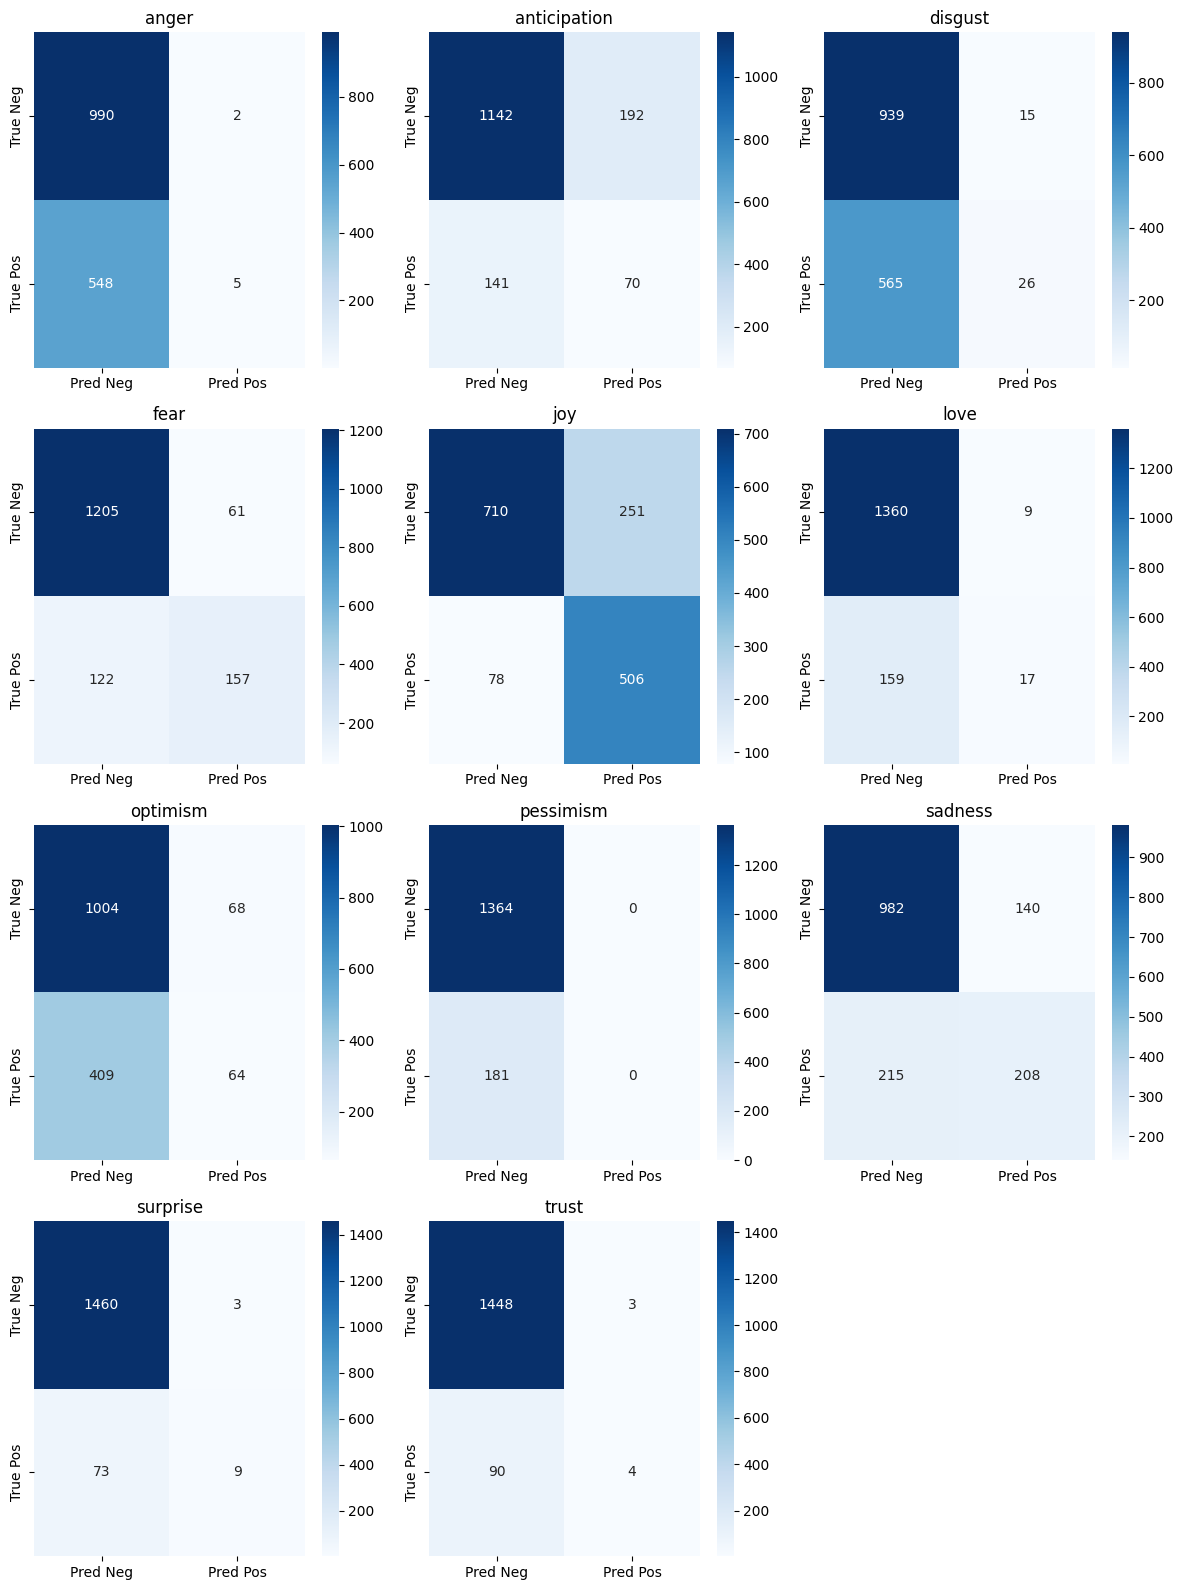

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


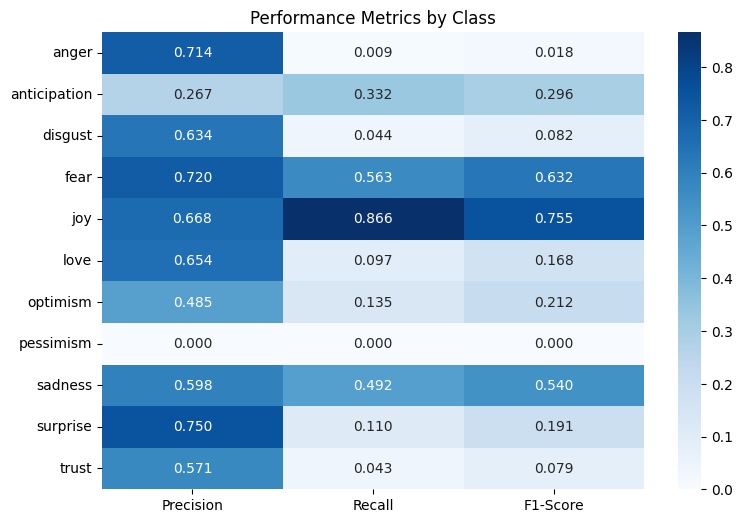

<Figure size 1200x533.333 with 0 Axes>

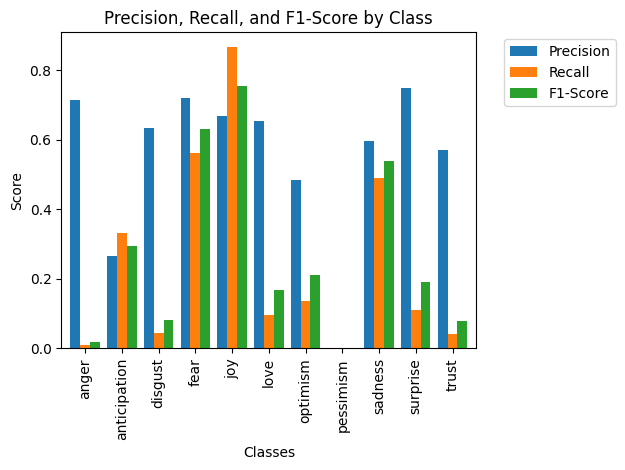

{'macro_avg': {'precision': 0.5510948617581143,
  'recall': 0.24453484259165437,
  'f1': 0.2702466847604758},
 'per_class': {'Precision': {'anger': 0.7142857142857143,
   'anticipation': 0.26717557251908397,
   'disgust': 0.6341463414634146,
   'fear': 0.7201834862385321,
   'joy': 0.6684280052840158,
   'love': 0.6538461538461539,
   'optimism': 0.48484848484848486,
   'pessimism': 0.0,
   'sadness': 0.5977011494252874,
   'surprise': 0.75,
   'trust': 0.5714285714285714},
  'Recall': {'anger': 0.009041591320072333,
   'anticipation': 0.33175355450236965,
   'disgust': 0.043993231810490696,
   'fear': 0.5627240143369175,
   'joy': 0.8664383561643836,
   'love': 0.09659090909090909,
   'optimism': 0.13530655391120508,
   'pessimism': 0.0,
   'sadness': 0.491725768321513,
   'surprise': 0.10975609756097561,
   'trust': 0.0425531914893617},
  'F1-Score': {'anger': 0.017857142857142856,
   'anticipation': 0.2959830866807611,
   'disgust': 0.08227848101265822,
   'fear': 0.6317907444668008

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

In [ ]:
df_test = pd.read_csv(data_folder/'test.csv')

In [ ]:
stack_dataset_test = Dataset.from_pandas(df_test)

In [ ]:
# List of emotion columns
emotion_columns = ["anger", "anticipation", "disgust", "fear", "joy", "love",
                   "optimism", "pessimism", "sadness", "surprise", "trust"]

# Create a new column with the names of emotions where the value is 1
df_test["emotions"] = df_test[emotion_columns].apply(
    lambda row: " ".join([emotion for emotion in emotion_columns if row[emotion] == 1]), axis=1
)

# Display the DataFrame
print(df_test)

              ID                                              Tweet anger  \
0     2018-01559  @Adnan__786__ @AsYouNotWish Dont worry Indian ...  NONE   
1     2018-03739  Academy of Sciences, eschews the normally sobe...  NONE   
2     2018-00385                  I blew that opportunity -__- #mad  NONE   
3     2018-03001             This time in 2 weeks I will be 30... 😥  NONE   
4     2018-01988  #Deppression is real. Partners w/ #depressed p...  NONE   
...          ...                                                ...   ...   
3254  2018-03848  shaft abrasions from panties merely shifted to...  NONE   
3255  2018-00416  @lomadia heard of Remothered? Indie horror gam...  NONE   
3256  2018-03717        All this fake outrage. Y'all need to stop 🤣  NONE   
3257  2018-03504  Would be ever so grateful if you could record ...  NONE   
3258  2018-00115  I'm the wholesome drunk that sends people meme...  NONE   

     anticipation disgust  fear   joy  love optimism pessimism sadness  \
0

In [ ]:
stack_dataset_test = Dataset.from_pandas(df_test)

In [ ]:
selected_columns_test = {
    'text': stack_dataset_test['Tweet'],
    'tag': stack_dataset_test['emotions']
}

# Create a new dataset with the selected columns
stack_selected_columns_test = Dataset.from_dict(selected_columns_test)

In [ ]:
stack_selected_columns_test

Dataset({
    features: ['text', 'tag'],
    num_rows: 3259
})

In [ ]:
# Set the format to Pandas
stack_selected_columns_test.set_format(type='pandas')

In [ ]:
df_test_1 = stack_selected_columns_test[:]

In [ ]:
# Remove existing quotes first (if any) and then add just one set
import json
df_test_1['label'] = df_test_1['tag'].str.split().apply(lambda x: json.dumps([tag.strip() for tag in x]))


In [ ]:
df_test

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,emotions
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,shaft abrasions from panties merely shifted to...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3255,2018-00416,@lomadia heard of Remothered? Indie horror gam...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3256,2018-03717,All this fake outrage. Y'all need to stop 🤣,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3257,2018-03504,Would be ever so grateful if you could record ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,


In [ ]:
df_final_test = df_test_1[['text', 'label']]

In [ ]:
stack_selected_columns_final_test = Dataset.from_pandas(df_final_test)

In [ ]:
test_split = stack_selected_columns_final_test

In [ ]:
test_split

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

In [ ]:
test_split = test_split.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
testset_filtered = test_split.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
testset_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
test_inference_results = run_inference(seed = 42,
              dataset=testset_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'test_complete_generations')

Model device for inference: cuda:0


Generating responses: 100%|██████████| 82/82 [01:35<00:00,  1.17s/it]

Saved inference_results to: /content/drive/MyDrive/NLP UTD/models/qwen_qlora_lmh/test_complete_generations.json


In [ ]:
file_name = model_folder/'test_complete_generations.json'
with open(file_name, 'r') as f:
    test_inference_results = json.load(f)

In [ ]:
# Get predictions using our pipeline
# First extract content from model outputs
test_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in test_inference_results
]

# Clean and convert predictions and ground truth
test_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in test_extracted_outputs
]

test_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in test_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
test_labels_binary = mlb.transform(test_labels)
test_predictions_binary = mlb.transform(test_predictions)

# Print samples and shapes
print("Sample of true labels:", test_labels[:5])
print("Sample of predictions:", test_predictions[:5])
print("\nBinary format:")
print("Labels shape:", test_labels_binary.shape)
print("Predictions shape:", test_predictions_binary.shape)

Sample of true labels: [[], [], [], [], []]
Sample of predictions: [['fear', 'optimism'], ['sadness'], ['sadness'], ['joy'], ['fear']]

Binary format:
Labels shape: (3259, 11)
Predictions shape: (3259, 11)


In [ ]:
test_metrics = compute_metrics(test_labels_binary , test_predictions_binary)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
test_metrics

{'f1_micro': 0.0,
 'f1_macro': 0.0,
 'accuracy_label': 0.894585623029931,
 'accuracy_all': 0.07425590671985272}

In [ ]:
wandb.log({"test_f1_macro": test_metrics["f1_macro"]})

In [ ]:
wandb.finish()

eval/loss,█▇▆▄▄▅▃▃▂▂▃▂▂▂▁▁▁▁▁
eval/runtime,▅▁▆▆█▇▃▁▂▄▄▂▂▁▆▅▂▁▅
eval/samples_per_second,▄█▃▃▁▂▆█▇▅▅▇▇█▃▄▇█▄
eval/steps_per_second,▄█▃▃▁▂▆█▇▅▅▇▇█▃▄▇█▄
test_f1_macro,▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/grad_norm,█▆▄▅▂▃▄▄▃▃▃▃▃▁▁▂▁▁▂
train/learning_rate,██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
train/loss,█▅▃▃▃▃▃▂▃▂▂▂▂▁▂▁▂▁▁
valid_f1_macro,▁


In [ ]:
best_model_checkpoint_step=380
model_folder = base_folder/'models/qwen_qlora_lmh'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.padding_side='left'
tokenizer.pad_token

'<|endoftext|>'

In [ ]:
inference_results= run_inference(seed = 42,
              dataset=testset_filtered.select(range(10)),
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter)

Model device for inference: cuda:0


Generating responses: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


In [ ]:
inference_results[0]

{'input': '@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'generated_output': 'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: @Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell ### LABEL: [] ### ["fears", ["optimistic"]',
 'ground_truth': '[]'}

In [ ]:
extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in inference_results
]

In [ ]:
# Clean and convert predictions and ground truth
predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in extracted_outputs
]

In [ ]:
ag_map = {0: 'anger', 1: 'anticipation', 2: 'disgust', 3: 'fear', 4: 'joy', 5: 'love',
                   6: 'optimism', 7: 'pessimism', 8: 'sadness',  9: 'surprise', 10: 'trust'}

predictions = test_predictions_binary

predicted_label_names = []
for pred in predictions:
    sample_labels = [ag_map[i] for i, is_present in enumerate(pred) if is_present]
    predicted_label_names.append(sample_labels)

print(predicted_label_names)

[['fear', 'optimism'], ['sadness'], ['sadness'], ['joy'], ['fear'], ['anticipation', 'fear'], ['joy'], ['joy'], [], ['fear', 'sadness'], ['joy'], ['joy'], ['joy'], ['joy'], ['sadness'], ['joy'], ['joy'], ['joy'], ['anticipation', 'joy'], ['sadness'], ['joy'], ['joy'], ['anticipation', 'joy'], ['anticipation', 'disgust'], ['joy'], ['anticipation', 'fear'], ['joy'], ['love', 'trust'], ['fear'], ['anticipation'], ['joy'], ['fear', 'sadness'], [], ['anticipation', 'disgust'], ['optimism'], ['fear', 'sadness'], ['joy'], ['optimism'], ['joy'], [], ['sadness'], ['joy'], ['anticipation'], ['anticipation', 'disgust'], [], ['sadness'], ['anticipation', 'joy'], ['optimism'], ['anticipation', 'joy'], ['joy'], ['anticipation', 'joy'], ['sadness'], ['fear', 'optimism'], ['joy'], [], [], ['fear', 'joy'], ['joy'], ['optimism'], ['sadness'], ['joy'], ['joy'], [], ['joy'], ['sadness'], ['anticipation', 'disgust'], ['joy'], ['joy'], ['anticipation', 'joy'], ['joy'], ['anticipation', 'disgust'], ['sadness

In [ ]:
# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(test_predictions_binary, columns=class_names)

In [ ]:
# Add the 'ID' column from the test set
predictions_df.insert(0, 'ID', df_test['ID'])

In [ ]:
# Ensure the columns are in the correct order
column_order = ['ID'] + class_names
predictions_df = predictions_df[column_order]
result_df = predictions_df

In [ ]:
result_df.to_csv(data_folder/'govardhan8th_part1.csv', index=False)

In [ ]:
result_df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,0,0,0,1,0,0,1,0,0,0,0
1,2018-03739,0,0,0,0,0,0,0,0,1,0,0
2,2018-00385,0,0,0,0,0,0,0,0,1,0,0
3,2018-03001,0,0,0,0,1,0,0,0,0,0,0
4,2018-01988,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,0,1,0,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,1,0,0,0,0,0,0,0
3256,2018-03717,0,1,0,0,0,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,0,0,0,0,0,0
